# Set up

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=6004929dd4364761c81536b5a7709170e9dc83ff410fc486e58ef7796fb817a4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=8096cc050487c347abbd0baf61875f4ed279e9bb58c17d9e73e8f26fe6c1bcad
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 6.12 MiB/s, done.
Resolving deltas: 100% (3/3), done.


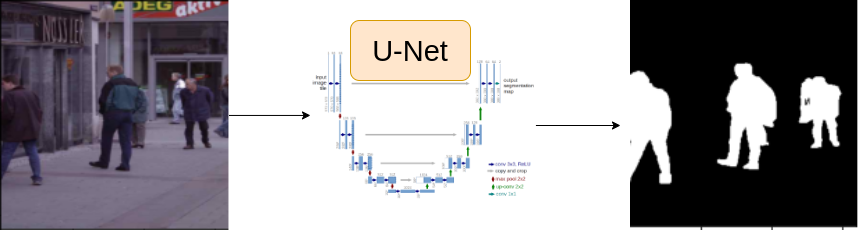

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
EPOCHS =25
LR = 0.003
IMAGE_SIZE = 256

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [44]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [45]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

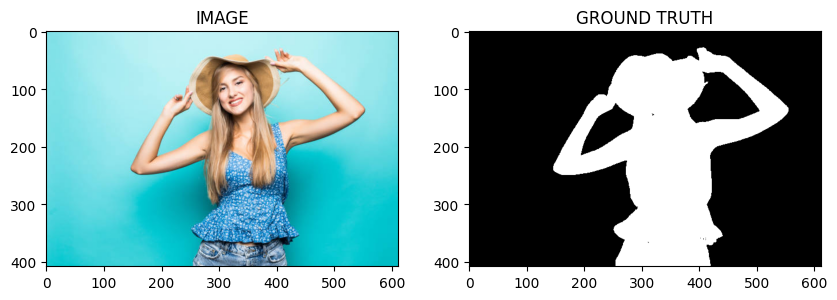

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [47]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [48]:
import albumentations as A

In [49]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
    ], is_check_shapes=False)

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ], is_check_shapes=False)

# Create Custom Dataset

In [50]:
from torch.utils.data import Dataset

In [51]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):

        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        row = self.df.iloc[index]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = -1)


        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return (image, mask)


In [52]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [53]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


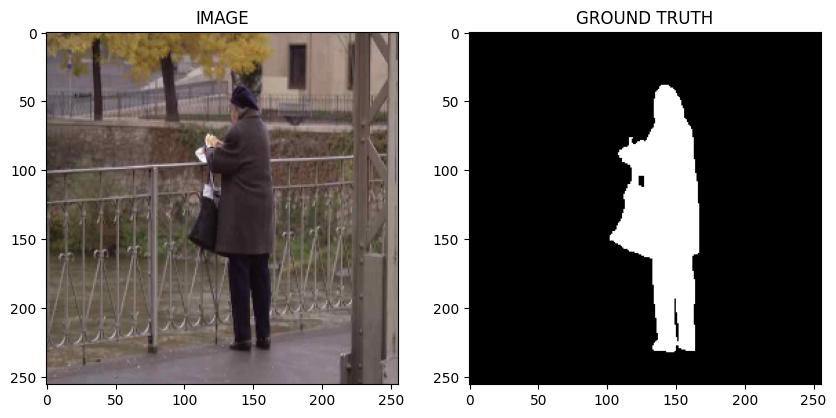

In [57]:
idx = 4

image, mask = trainset[idx]

helper.show_image(image, mask)

# Load dataset into batches

In [58]:
from torch.utils.data import DataLoader

In [61]:
BATCH_SIZE = 16

In [62]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [63]:
print(F'tOTAL NUMBER OF BATCHES IN TRAINLOADER : {len(trainloader)}')
print(F'tOTAL NUMBER OF BATCHES IN VALIDLOADER : {len(validloader)}')

tOTAL NUMBER OF BATCHES IN TRAINLOADER : 15
tOTAL NUMBER OF BATCHES IN VALIDLOADER : 4


In [64]:
for image, mask in trainloader:
    break

In [65]:
print(f"One batch image shape : {image.shape}")
print(f"One batch mask : {mask.shape}")

One batch image shape : torch.Size([16, 3, 256, 256])
One batch mask : torch.Size([16, 1, 256, 256])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

# Create Train and Validation Function

# Train Model

# Inference